Author: Matthew M Murphy

Co-I: Information on classmates will not be posted.

This work was done for the AST443 course at Stony Brook University

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import stats
from scipy.stats import norm

## (4.1)
Generating the Master Dark

All science images used 60s exposure time, so only one master dark at this exposure time is needed. A median combine is better an average combine because any pixel that is 'hot' in a single exposure will sway that pixel's mean.

In [2]:
# Opening all darks
d1 = fits.open('btm_hat_p23_b_DARK.00000001.DARK.FIT')
d2 = fits.open('btm_hat_p23_b_DARK.00000002.DARK.FIT')
d3 = fits.open('btm_hat_p23_b_DARK.00000003.DARK.FIT')
d4 = fits.open('btm_hat_p23_b_DARK.00000004.DARK.FIT')
d5 = fits.open('btm_hat_p23_b_DARK.00000005.DARK.FIT')
d6 = fits.open('btm_hat_p23_b_DARK.00000006.DARK.FIT')
d7 = fits.open('btm_hat_p23_b_DARK.00000007.DARK.FIT')
d8 = fits.open('btm_hat_p23_b_DARK.00000008.DARK.FIT')
d9 = fits.open('btm_hat_p23_b_DARK.00000009.DARK.FIT')
d10 = fits.open('btm_hat_p23_b_DARK.00000010.DARK.FIT')

d1 = d1[0].data
d2 = d2[0].data
d3 = d3[0].data
d4 = d4[0].data
d5 = d5[0].data
d6 = d6[0].data
d7 = d7[0].data
d8 = d8[0].data
d9 = d9[0].data
d10 = d10[0].data

# Median combining to construct the master frame
all_dark = [d1,d2,d3,d4,d5,d6,d7,d8,d9,d10]
all_dark = np.median(all_dark,axis=0)

master_dark = fits.PrimaryHDU(all_dark)
#master_dark.writeto('master_dark.FIT')

Similarly, we can construct a master flat field from our series of dome flats. Each flat was taken with 2s exposure time. Each flat taken has generally the same level of counts, so no rescaling is necessary. 

In [3]:
# Opening the flats
f1 = fits.open('btm_hat_p23_b_FLAT.00000228.FLAT.FIT')
f2 = fits.open('btm_hat_p23_b_FLAT.00000229.FLAT.FIT')
f3 = fits.open('btm_hat_p23_b_FLAT.00000230.FLAT.FIT')
f4 = fits.open('btm_hat_p23_b_FLAT.00000231.FLAT.FIT')
f5 = fits.open('btm_hat_p23_b_FLAT.00000232.FLAT.FIT')
f6 = fits.open('btm_hat_p23_b_FLAT.00000233.FLAT.FIT')
f7 = fits.open('btm_hat_p23_b_FLAT.00000234.FLAT.FIT')
f8 = fits.open('btm_hat_p23_b_FLAT.00000235.FLAT.FIT')
f9 = fits.open('btm_hat_p23_b_FLAT.00000236.FLAT.FIT')
f10 = fits.open('btm_hat_p23_b_FLAT.00000237.FLAT.FIT')

f1 = f1[0].data
f2 = f2[0].data
f3 = f3[0].data
f4 = f4[0].data
f5 = f5[0].data
f6 = f6[0].data
f7 = f7[0].data
f8 = f8[0].data
f9 = f9[0].data
f10 = f10[0].data

# Median combining to create the master flat
all_flat = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10]
all_flat = np.median(all_flat,axis=0)

# We normalize the master flat by its mode
flat_flat = all_flat.flatten()
flat_mode = stats.mode(flat_flat)[0][0]
master_flat = all_flat / flat_mode
m_flat = fits.PrimaryHDU(master_flat)
#m_flat.writeto('master_flat.FIT')

The master dark and master flat are applied to our science images in pyraf. The master dark is subtracted from the science images then the dark-corrected image is divided by the master flat.

Further, from these master frames, we can try to identify any bad (dead or hot) pixels. Hot pixels can be identified as outliers in the count distribution of our master dark frame. 

Master Dark Mean =  1064.33 counts
Master Dark Median =  1060.50 counts
Master Dark Mode =  1059.50 counts
Master Dark Standard Deviation =  143.64 counts


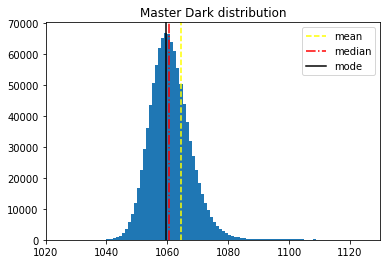

In [4]:
# Hot pixels are identified from the master dark
flat_dark = all_dark.flatten()
md_mean = np.mean(flat_dark)     #determining summary stats
md_median = np.median(flat_dark)
md_mode = stats.mode(flat_dark)[0][0]
md_sd = np.std(flat_dark)

# What are the summary statistics?
print('Master Dark Mean = ','%.2f'%(md_mean), 'counts')
print('Master Dark Median = ','%.2f'%(md_median), 'counts')
print('Master Dark Mode = ','%.2f'%(md_mode), 'counts')
print('Master Dark Standard Deviation = ','%.2f'%(md_sd), 'counts')

# Plotting the count distribution
plt.hist(flat_dark,range=[1025,1125],bins=100);
plt.axvline(x=md_mean,color='yellow',linestyle='--',label='mean')
plt.axvline(x=md_median,color='red',linestyle='-.',label='median')
plt.axvline(x=md_mode,color='black',label='mode')
plt.legend(loc='best')
plt.title('Master Dark distribution');

The counts of our master dark frame look quite normally distributed. The mean is slightly skewed toward high count values but the mode seems like a good, central description of our data. Hot pixels are outliers at high count values. We will cut them based on a 5$\sigma$ clip from the mode. We do not show the boundaries of this clip on the above histogram as they lie far beyond the shown range, which contains the majority of the counts, and would dilute the plot. 

In [5]:
hot_cut = md_mode + 5*md_sd # hot pixels have counts > hot_cut

Similarly, dead pixels are identified from the master flat field. These are pixels which give little to no counts for an incident signal and appear as low outliers.

Master Flat Mean =  0.98
Master Flat Median =  0.98
Master Flat Mode =  1.00
Master Flat Standard Deviation =  0.02


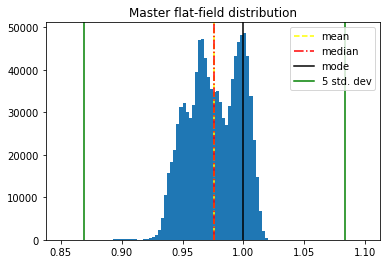

In [6]:
# Dead pixels are identified from the master flat
flat_mflat = master_flat.flatten()
mf_mean = np.mean(flat_mflat)
mf_median = np.median(flat_mflat) 
mf_mode = stats.mode(flat_mflat)[0][0]
mf_sd = np.std(flat_mflat)

# What are these summary statistics?
print('Master Flat Mean = ','%.2f'%(mf_mean))
print('Master Flat Median = ','%.2f'%(mf_median))
print('Master Flat Mode = ','%.2f'%(mf_mode))
print('Master Flat Standard Deviation = ','%.2f'%(mf_sd))

plt.hist(flat_mflat,range=[0.85,1.10],bins=100);
plt.axvline(x=mf_mean,color='yellow',linestyle='--',label='mean')
plt.axvline(x=mf_median,color='red',linestyle='-.',label='median')
plt.axvline(x=mf_mode,color='black',label='mode')
plt.axvline(x=mf_median+5*mf_sd,color='green',label='5 std. dev')
plt.axvline(x=mf_median-5*mf_sd,color='green')
plt.legend(loc='best')
plt.title('Master flat-field distribution');

In contrast to the dark frame, which is strongly Gaussian, the count distribution of the master flat field is bimodal. The mean and median of this distribution are approximately equivalent. We will again use a 5$\sigma$ clip, now defined from the median. The boundaries of this $\sigma$ clip are shown on the above histogram. They lie well beyond the range containing the majority of pixels, so we need not worry that this clip will actually reject a good pixel. 

In [7]:
dead_cut = mf_median - 5*md_sd  #dead pixels have counts < dead_cut

Now that we have defined criteria for identifying hot and dead pixels, we can construct a bad pixel mask.

In [8]:
mask = 0*all_flat  # array of 0s of same size as images
mask += 1          # setting all values = 1

for i,list in enumerate(all_dark):
    for j,value in enumerate(list):
        if value >= hot_cut:
            mask[i,j] = 0
for i,list in enumerate(master_flat):
    for j,value in enumerate(list):
        if value <= dead_cut:
            mask[i,j] = 0
# All bad pixels have value set to 0
# Good pixels remain with value of 1
        
maskfit = fits.PrimaryHDU(mask)
#maskfit.writeto('pixelmask.FIT')

The pixel mask is an array of the same size as our images. On it, good pixels have value '1' and bad pixels have value '0'. We output this to a .fit file.

As mentioned, the darks and flats were applied to our science images in pyraf. The master dark was subtracted from the science images, then that result was divided by the flat-field. Now that these images have been corrected, we can align them to WCS and extract the fluxes.

## (4.2)

The dark and sensitivity calibrated images can now be solved for their WCS. This was done using Astrometry.net on the local SUNY Stony Brook Astronomy Computing machines.

## (4.3)

With the WCS solved images, we can now identify and measure the flux of each source in the images. This is done using Source Extractor on the SBU machines. We used an aperture of 8.137 pixels. This was performed on all images. The observing time, flux, and flux error was extracted for the target planet-host system and for ten reference stars. This data, which is our preliminary light curve data, is saved in separate .dat files for each star. The specific reference stars chosen are given in the report. 

## (4.4)

We will now scale the flux and error on the flux of each star by that star's average flux over the length of observations.

First, we have to extract the flux data from the .dat files. 

In [3]:
host_data = open('host_data.dat')    #opening each star's data file
ref1_data = open('refstar1_data.dat')
ref2_data = open('refstar2_data.dat')
ref3_data = open('refstar3_data.dat')
ref4_data = open('refstar4_data.dat')
ref5_data = open('refstar5_data.dat')
ref6_data = open('refstar6_data.dat')
ref7_data = open('refstar7_data.dat')
ref8_data = open('refstar8_data.dat')
ref9_data = open('refstar9_data.dat')
ref10_data = open('refstar10_data.dat')
from astropy.time import Time

# We have to unpack the time and flux data of each

# unpacking host star flux data
list = []
for line in host_data:
    list += [line.split()]
host_flux = [float(x[2]) for x in list]      #flux
host_flux_err = [float(x[3]) for x in list]  #flux error
obs_time = [x[5] for x in list]              #image time (UTC)

# converting time of obs into julian date format
for i,time in enumerate(obs_time):
    t_str = '2019-09-19 '+time
    T = Time(t_str, format='iso',scale='utc')
    obs_time[i] = T.jd
    
#unpacking reference star fluxes
list = []
for line in ref1_data:
    list += [line.split()]
ref1_flux = [float(x[2]) for x in list]     #flux
ref1_flux_err = [float(x[3]) for x in list] #flux error
list = []
for line in ref2_data:
    list += [line.split()]
ref2_flux = [float(x[2]) for x in list]     #flux
ref2_flux_err = [float(x[3]) for x in list] #flux error
list = []
for line in ref3_data:
    list += [line.split()]
ref3_flux = [float(x[2]) for x in list]     #flux
ref3_flux_err = [float(x[3]) for x in list] #flux error
list = []
for line in ref4_data:
    list += [line.split()]
ref4_flux = [float(x[2]) for x in list]     #flux
ref4_flux_err = [float(x[3]) for x in list] #flux error
list = []
for line in ref5_data:
    list += [line.split()]
ref5_flux = [float(x[2]) for x in list]     #flux
ref5_flux_err = [float(x[3]) for x in list] #flux error
list = []
for line in ref6_data:
    list += [line.split()]
ref6_flux = [float(x[2]) for x in list]     #flux
ref6_flux_err = [float(x[3]) for x in list] #flux error
list = []
for line in ref7_data:
    list += [line.split()]
ref7_flux = [float(x[2]) for x in list]     #flux
ref7_flux_err = [float(x[3]) for x in list] #flux error
list = []
for line in ref8_data:
    list += [line.split()]
ref8_flux = [float(x[2]) for x in list]     #flux
ref8_flux_err = [float(x[3]) for x in list] #flux error
list = []
for line in ref9_data:
    list += [line.split()]
ref9_flux = [float(x[2]) for x in list]     #flux
ref9_flux_err = [float(x[3]) for x in list] #flux error
list = []
for line in ref10_data:
    list += [line.split()]
ref10_flux = [float(x[2]) for x in list]     #flux
ref10_flux_err = [float(x[3]) for x in list] #flux error

host_data.close()
ref1_data.close()
ref2_data.close()
ref3_data.close()
ref4_data.close()
ref5_data.close()
ref6_data.close()
ref7_data.close()
ref8_data.close()
ref9_data.close()
ref10_data.close()

Now, we can find each star's mean flux over the observing period.

In [4]:
# Finding the mean of each ref star's flux data
ref1_fmean = np.mean(ref1_flux)
ref2_fmean = np.mean(ref2_flux)
ref3_fmean = np.mean(ref3_flux)
ref4_fmean = np.mean(ref4_flux)
ref5_fmean = np.mean(ref5_flux)
ref6_fmean = np.mean(ref6_flux)
ref7_fmean = np.mean(ref7_flux)
ref8_fmean = np.mean(ref8_flux)
ref9_fmean = np.mean(ref9_flux)
ref10_fmean = np.mean(ref10_flux)

Now, we scale the reference star fluxes by their corresponding mean. 

In [5]:
# Now performing the rescaling
ref1_sflux = ref1_flux / ref1_fmean
ref1_sflux_err = ref1_flux_err / ref1_fmean
ref2_sflux = ref2_flux / ref2_fmean
ref2_sflux_err = ref2_flux_err / ref2_fmean
ref3_sflux = ref3_flux / ref3_fmean
ref3_sflux_err = ref3_flux_err / ref3_fmean
ref4_sflux = ref4_flux / ref4_fmean
ref4_sflux_err = ref4_flux_err / ref4_fmean
ref5_sflux = ref5_flux / ref5_fmean
ref5_sflux_err = ref5_flux_err / ref5_fmean
ref6_sflux = ref6_flux / ref6_fmean
ref6_sflux_err = ref6_flux_err / ref6_fmean
ref7_sflux = ref7_flux / ref7_fmean
ref7_sflux_err = ref7_flux_err / ref7_fmean
ref8_sflux = ref8_flux / ref8_fmean
ref8_sflux_err = ref8_flux_err / ref8_fmean
ref9_sflux = ref9_flux / ref9_fmean
ref9_sflux_err = ref9_flux_err / ref9_fmean
ref10_sflux = ref10_flux / ref10_fmean
ref10_sflux_err = ref10_flux_err / ref10_fmean

The light curves of these scaled fluxes help visualize relative variations due to airmass changes, atmospheric effects, and intrinsic variations in stellar brightness. Let's take a look at these light curves. 

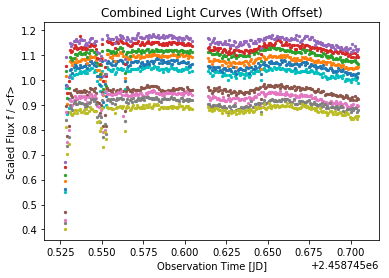

In [6]:
# Let's now examine the Scaled lightcurves of our reference stars
# we can use these to identify any bad stars / exposures
# plotting all light curves together with offsets
offset_r1 = [val+0.025 for val in ref1_sflux]
offset_r2 = [val+0.05 for val in ref2_sflux]
offset_r3 = [val+0.075 for val in ref3_sflux]
offset_r4 = [val+0.1 for val in ref4_sflux]
offset_r5 = [val+0.125 for val in ref5_sflux]
offset_r6 = [val+0.15 for val in ref6_sflux]
offset_r7 = [val-0.05 for val in ref7_sflux]
offset_r8 = [val-0.075 for val in ref8_sflux]
offset_r9 = [val-0.1 for val in ref9_sflux]
offset_r10 = [val-0.125 for val in ref10_sflux]
plt.scatter(obs_time,offset_r1,color='c',s=5)
plt.scatter(obs_time,offset_r2,s=5)
plt.scatter(obs_time,offset_r3,s=5)
plt.scatter(obs_time,offset_r4,s=5)
plt.scatter(obs_time,offset_r5,s=5)
plt.scatter(obs_time,offset_r6,s=5)
plt.scatter(obs_time,offset_r7,s=5)
plt.scatter(obs_time,offset_r8,s=5)
plt.scatter(obs_time,offset_r9,s=5)
plt.scatter(obs_time,offset_r10,s=5)
plt.xlabel('Observation Time [JD]')
plt.ylabel('Scaled Flux f / <f>')
plt.title('Combined Light Curves (With Offset)')
plt.savefig('OffsetLightCurves_norejection.png')
plt.show()

We do not identify any bad reference stars. We do notice several major features across all curves:

- There is a drop off in flux near the start of observations
- Flux drop offs around images 30-40 and another at about image 50

We will reject bad exposures according to the criteria that bad exposures are those with a scaled flux $f / \langle f \rangle < 0.98$. This cuts out the exposures corresponding to the flux drop offs noted above and does not reject any exposures within the expected transit duration. 

In [7]:
# Rejecting the bad exposures
# Need to run all cells above before re-running this one!!

rej_index_list = []
for i,time in enumerate(obs_time):
    if (i<60 and ref1_sflux[i]<0.98): 
        rej_index_list.append(i)

def reject(data_list,reject_list):
    new_list = []
    for j,val in enumerate(data_list):
        if j not in reject_list:
            new_list.append(val)
    return new_list
        
original_num = len(obs_time)    
obs_time = reject(obs_time,rej_index_list)
new_num = len(obs_time)
# how many exposures were rejected?
print(original_num - new_num, ' exposures rejected')

# Applying this criteria
host_flux = reject(host_flux,rej_index_list)
host_flux_err = reject(host_flux_err,rej_index_list)
ref1_sflux = reject(ref1_sflux,rej_index_list)
ref1_sflux_err = reject(ref1_sflux_err,rej_index_list)
ref2_sflux = reject(ref2_sflux,rej_index_list)
ref2_sflux_err = reject(ref2_sflux_err,rej_index_list)
ref3_sflux = reject(ref3_sflux,rej_index_list)
ref3_sflux_err = reject(ref3_sflux_err,rej_index_list)
ref4_sflux = reject(ref4_sflux,rej_index_list)
ref4_sflux_err = reject(ref4_sflux_err,rej_index_list)
ref5_sflux = reject(ref5_sflux,rej_index_list)
ref5_sflux_err = reject(ref5_sflux_err,rej_index_list)
ref6_sflux = reject(ref6_sflux,rej_index_list)
ref6_sflux_err = reject(ref6_sflux_err,rej_index_list)
ref7_sflux = reject(ref7_sflux,rej_index_list)
ref7_sflux_err = reject(ref7_sflux_err,rej_index_list)
ref8_sflux = reject(ref8_sflux,rej_index_list)
ref8_sflux_err = reject(ref8_sflux_err,rej_index_list)
ref9_sflux = reject(ref9_sflux,rej_index_list)
ref9_sflux_err = reject(ref9_sflux_err,rej_index_list)
ref10_sflux = reject(ref10_sflux,rej_index_list)
ref10_sflux_err = reject(ref10_sflux_err,rej_index_list)

12  exposures rejected


In total, we rejected twelve exposures. Let's see the resulting light curves.

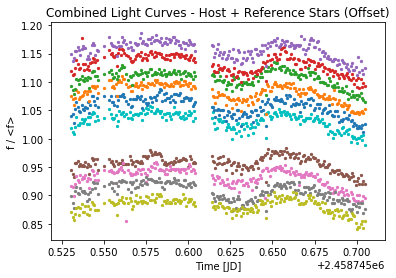

In [8]:
# All ref star curves with offset
offset_r1 = [val+0.025 for val in ref1_sflux]
offset_r2 = [val+0.05 for val in ref2_sflux]
offset_r3 = [val+0.075 for val in ref3_sflux]
offset_r4 = [val+0.1 for val in ref4_sflux]
offset_r5 = [val+0.125 for val in ref5_sflux]
offset_r6 = [val+0.15 for val in ref6_sflux]
offset_r7 = [val-0.05 for val in ref7_sflux]
offset_r8 = [val-0.075 for val in ref8_sflux]
offset_r9 = [val-0.1 for val in ref9_sflux]
offset_r10 = [val-0.125 for val in ref10_sflux]
plt.scatter(obs_time,offset_r1,color='c',s=5)
plt.scatter(obs_time,offset_r2,s=5)
plt.scatter(obs_time,offset_r3,s=5)
plt.scatter(obs_time,offset_r4,s=5)
plt.scatter(obs_time,offset_r5,s=5)
plt.scatter(obs_time,offset_r6,s=5)
plt.scatter(obs_time,offset_r7,s=5)
plt.scatter(obs_time,offset_r8,s=5)
plt.scatter(obs_time,offset_r9,s=5)
plt.scatter(obs_time,offset_r10,s=5)
plt.xlabel('Time [JD]')
plt.ylabel('f / <f>')
plt.title('Combined Light Curves - Host + Reference Stars (Offset)')
plt.show()

This plot shows the light curves of all reference stars after rejecting twelve bad exposures. The curves are offset by a small constant so as to view them all on the same axis. The flux drop offs noted in the previous plot have been removed from analysis, so now these curves look good across the whole period. The relatively small variations in these curves are due to atmospheric effects that affect each star equally. 

The gap near the middle of the observing period was the GEM flip of the telescope.

## (4.5)
Now computing the weighted mean and corresponding error on the weighted mean of our reference stars.

In [9]:
mu_ref  = []   # weighted mean; mu_i^ref
sig_ref = []   # error on weighted mean; sigma_i^ref
r = []         # f_sci / mu_ref
r_err = []     # error on r 

for i,time in enumerate(obs_time):
    rf1 = ref1_sflux[i]/pow(ref1_sflux_err[i],2)  # f^ref_j / (sig^ref_j)^2
    re1 = 1/pow(ref1_sflux_err[i],2)              # 1 / (sig^ref_j)^2
    rf2 = ref2_sflux[i]/pow(ref2_sflux_err[i],2)  # calculated for each ref star
    re2 = 1/pow(ref2_sflux_err[i],2)              # on each exposure
    rf3 = ref3_sflux[i]/pow(ref3_sflux_err[i],2)
    re3 = 1/pow(ref3_sflux_err[i],2)
    rf4 = ref4_sflux[i]/pow(ref4_sflux_err[i],2)
    re4 = 1/pow(ref4_sflux_err[i],2)
    rf5 = ref5_sflux[i]/pow(ref5_sflux_err[i],2)
    re5 = 1/pow(ref5_sflux_err[i],2)
    rf6 = ref6_sflux[i]/pow(ref6_sflux_err[i],2)
    re6 = 1/pow(ref6_sflux_err[i],2)
    rf7 = ref7_sflux[i]/pow(ref7_sflux_err[i],2)
    re7 = 1/pow(ref7_sflux_err[i],2)
    rf8 = ref8_sflux[i]/pow(ref8_sflux_err[i],2)
    re8 = 1/pow(ref8_sflux_err[i],2)
    rf9 = ref9_sflux[i]/pow(ref9_sflux_err[i],2)
    re9 = 1/pow(ref9_sflux_err[i],2)
    rf10 = ref10_sflux[i]/pow(ref10_sflux_err[i],2)
    re10 = 1/pow(ref10_sflux_err[i],2)
    
    num_sum = rf1+rf2+rf3+rf4+rf5+rf6+rf7+rf8+rf9+rf10 #sum [f_j / (sig_j)^2]
    den_sum = re1+re2+re3+re4+re5+re6+re7+re8+re9+re10 #sum [1 / (sig_j)^2]
    
    mu = num_sum / den_sum   # weighted mean on i-th exposure
    mu_ref.append(mu)
    
    sig = np.sqrt(1/den_sum) # error on the weighted mean
    sig_ref.append(sig)
    
    r_i = host_flux[i]/mu   # target flux / weighted mean flux
    r.append(r_i)
    
    A = sig/mu
    B = host_flux_err[i]/host_flux[i]
    sig_r = r_i*np.sqrt( pow(A,2) + pow(B,2) )
    r_err.append(sig_r)    # error on r  

In [16]:
# Writing relevant quantities into a .txt file
# 1) observation time, 2) target flux and error, 3) weighted mean and error, 4) r and error
text = open("target_photometry.txt","w")
text.write('#Obs_time [JD]\n#Target flux\n#Target flux error\n')
text.write('#Weighted mean of reference stars\n#Error in weighted mean\n')
text.write('#r = target flux/weighted mean\n#error in r\n')

for i,val in enumerate(obs_time):
    text.write(str(obs_time[i])+'\t'+str(host_flux[i])+'\t'+str(host_flux_err[i])+'\t'+str(mu_ref[i])+
               '\t'+str(sig_ref[i])+'\t'+str(r[i])+'\t'+str(r_err[i])+'\n')
text.close()

By scaling the target flux to the weighted mean of the reference stars, we account for any atmospheric effects that would obscure the transit signal. Let's take a look at the resulting light curve.

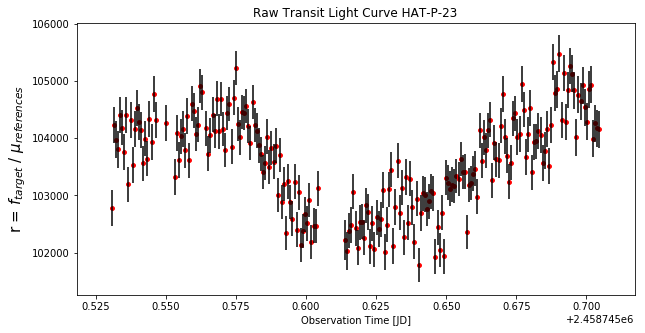

In [10]:
plt.figure(figsize=(10,5));
plt.scatter(obs_time,r,s=15,color='red');
plt.ylabel('r = $f_{target}$ / $\mu_{references}$',fontsize=15)
plt.xlabel('Observation Time [JD]',fontsize=10)
plt.title('Raw Transit Light Curve HAT-P-23')
plt.errorbar(obs_time,r, yerr=r_err, xerr = None, ecolor='black',ls='none');
plt.savefig('RawLightCurve.png')
plt.show()

To determine the transit depth from this light curve, we have to normalize this by the star's base-line flux. To do this, we must isolate the images outside of transit from those inside the transit. 

In [11]:
# An upper limit transit duration was calculated by assuming b=0
#  This gave the following times:
t_ingress = '2019-09-19 01:35:54'   #expected start of transit (UTC)
t_mid = '2019-09-19 02:56:36'       #expected midpoint (UTC)
t_egress  = '2019-09-19 04:17:18'   #expected end of transit (UTC)

# Converting to JD format
t_ingress = Time(t_ingress,format='iso',scale='utc')
t_ingress_JD = t_ingress.jd
t_mid = Time(t_mid,format='iso',scale='utc')
t_mid_JD = t_mid.jd
t_egress = Time(t_egress,format='iso',scale='utc')
t_egress_JD = t_egress.jd

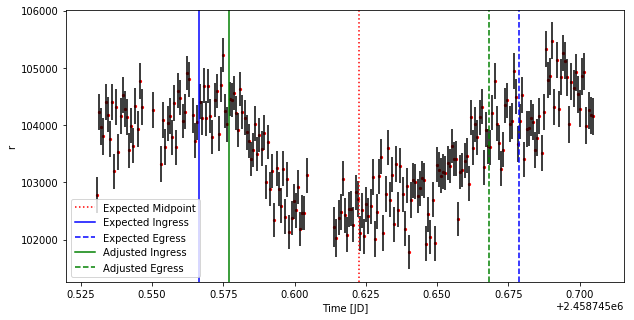

In [12]:
# Let's overlay the ingress & egress times onto the light curve to 
#    see how they match up with the data
plt.figure(figsize=(10,5));
plt.scatter(obs_time,r,s=5,color='red');
plt.axvline(x=t_mid_JD,color='red',linestyle=':',label='Expected Midpoint')
plt.axvline(x=t_ingress_JD,color='blue',label='Expected Ingress')
plt.axvline(x=t_egress_JD,color='blue',linestyle='--',label='Expected Egress')

# expected ingress and egress don't seem to match up with when
#   the data suggests the transit starts and ends
#   the actual duration is therefore less than our estimate
#   but we can adjust 

# estimate of actual ingress based on data
ingress_adj = 0.577+2.458745e6   # [JD]  
#   judgement error of ~ 0.002 JD here (~2.9 minutes)

# plotting this estimate, it is more accurate than the expected time
plt.axvline(x=ingress_adj,color='green',label='Adjusted Ingress')

# calculating the time difference between this new ingress time and the 
#   expected midpoint tells us how much to adjust the egress time as well
time_diff = abs(ingress_adj - t_ingress_JD)
egress_adj = t_egress_JD - time_diff

# plotting the adjusted egress time
plt.axvline(x=egress_adj,color='green',linestyle='--',label='Adjusted Egress')

plt.ylabel('r')
plt.xlabel('Time [JD]')
plt.legend(loc='lower left')
plt.errorbar(obs_time,r, yerr=r_err, xerr = None, ecolor='black',ls='none');
plt.savefig('IngressEgressplot.png')

This plot shows the target light curve with specific times overlayed. The leftmost solid line is the expected transit ingress and the rightmost solid line is the actual transit ingress that we determined based on this curve. The middle dotted line is the expected midpoint, which matches well. The leftmost dashed line is the actual egress determined from this curve, and the rightmost dashed line is the expected egress. 

The transit occured between the actual ingress and egress, that is between the rightmost solid line and the leftmost dashed line. Now that this has been determined, we can isolate the exposures before and after transit. Since there is a lot of variation in our light curve after the transit, we will only use the exposures before the transit in our analysis of the baseline.

Baseline flux =  104140.9


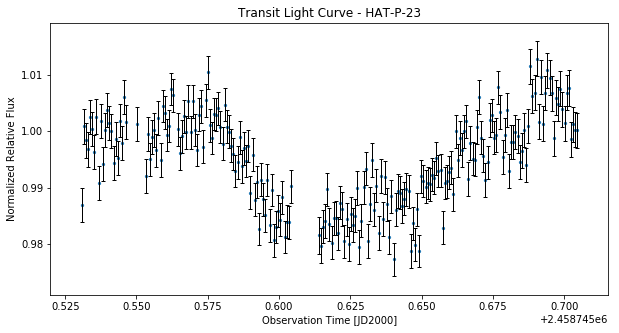

In [16]:
itime = ingress_adj

# determining the baseline flux
basef = []
basef_err = []
for i,time in enumerate(obs_time):
    if (time<=itime):
        basef.append(r[i])
r_base = np.mean(basef)
print('Baseline flux = ','%.1f'%r_base)

# Now normalizing by baseline flux
r_norm = [x/r_base for x in r]
r_normerr = [x/r_base for x in r_err]
    
plt.figure(figsize=(10,5));    
plt.scatter(obs_time,r_norm,s=5)
plt.errorbar(obs_time,r_norm, yerr=r_normerr, xerr = None, ecolor='black',ls='none',lw=1,capsize=2);
plt.ylabel('Normalized Relative Flux')
plt.xlabel('Observation Time [JD2000]')
plt.title('Transit Light Curve - HAT-P-23');
plt.savefig('HATP23LightCurve.png')

Here is the first look at our target transit light curve. The y-axis is the target flux scaled by the weighted mean of the reference stars and then normalized by the baseline. That is, the y-axis represents the fraction of the star's light that is not blocked by the transiting planet. 

To determine the full depth, we have to isolate the region in which the full transit is occuring. That is, when $r = 1 - \epsilon$. To determine this, we find where $r$ reaches its local minimum value. Finding the start of this period and determining the time difference between then and the mid-point, we can extrapolate to determine when it ended. 

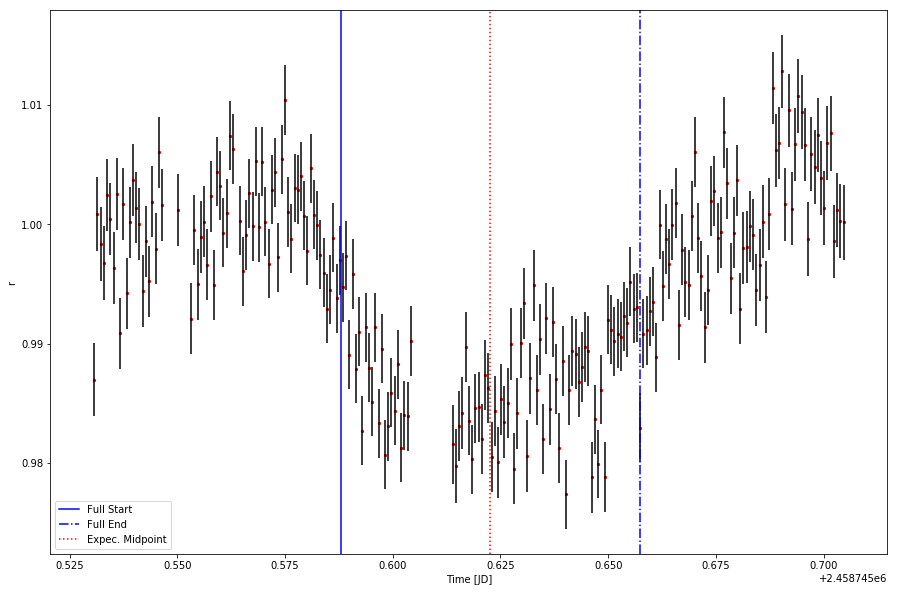

In [21]:
plt.figure(figsize=(15,10));
plt.scatter(obs_time,r_norm,s=5,color='red');

#estimated start of full transit
full_start = 0.588+2.458745e6   # error of ~0.004 here (5.8 minutes)
plt.axvline(x=full_start,color='blue',label='Full Start')

#now finding the estimated end of full transit
time_diff = abs(t_mid_JD-full_start)
full_end = t_mid_JD + time_diff
plt.axvline(x=full_end,color='blue',linestyle='-.',label='Full End')

#including the time of expected mid-point on the plot
plt.axvline(x=t_mid_JD,color='red',linestyle=':',label='Expec. Midpoint')
plt.ylabel('r')
plt.xlabel('Time [JD]')
plt.legend(loc='lower left')
plt.errorbar(obs_time,r_norm, yerr=r_normerr, xerr = None, ecolor='black',ls='none');

We have now isolated the full transit period, which occurs between the two blue lines. The line in the middle is the transit mid-point. 

Having isolated the times before transit and during full transit, we can finally calculate the depth. 

In [22]:
# Now we must calculate the average r outside and inside the transit
#   outside the transit, should have r = r_base ~ 1.0
#   during the transit, r = r_transit = 1 - epsilon

# Since there is some uncertainty in determining the exact ingress time
#    we can test several times within the range of uncertainty to get
#    an estimate on the error of r_base
ingress_times = [0.575,0.576,0.577,0.578,0.579]
ingress_times = [(x+2.458745e6) for x in ingress_times]

base_meanvals = []
base_meanerrvals = []
for i,itime in enumerate(ingress_times):
    base_f = []
    base_ferr = []
    for j,otime in enumerate(obs_time):
        if (otime<itime):  # using only exposures before transit for baseline
            base_f.append(r_norm[j])
            base_ferr.append(r_normerr[j])
    numsum = 0
    densum = 0
    for x,val in enumerate(base_f):
        numsum += (base_f[x]/pow(base_ferr[x],2))
        densum += (1/pow(base_ferr[x],2))
    base_meanvals.append(numsum / densum)
    base_meanerrvals.append(np.sqrt(1/densum))
numsum = 0
densum = 0
for i,val in enumerate(base_meanvals):
    numsum += (base_meanvals[i]/pow(base_meanerrvals[i],2))
    densum += (1/pow(base_meanerrvals[i],2))
r_b = numsum / densum
rerr_b = np.sqrt(1/densum)

# Doing the same for the in-transit times
tran_times = [0.584,0.585,0.586,0.588,0.590,0.591,0.592]
tran_times = [(x+2.458745e6) for x in tran_times]

tran_meanvals = []
tran_meanerrvals = []
for i,itime in enumerate(tran_times):
    time_diff = abs(t_mid_JD-itime)
    etime = t_mid_JD + time_diff
    tran_f = []
    tran_ferr = []
    for j,otime in enumerate(obs_time):
        if (otime>=itime and otime<=etime):
            tran_f.append(r_norm[j])
            tran_ferr.append(r_normerr[j])
    numsum = 0
    densum = 0
    for x,val in enumerate(tran_f):
        numsum += (tran_f[x]/pow(tran_ferr[x],2))
        densum += (1/pow(tran_ferr[x],2))
    tran_meanvals.append(numsum / densum)
    tran_meanerrvals.append(np.sqrt(1/densum))
numsum = 0
densum = 0
for i,val in enumerate(tran_meanvals):
    numsum += (tran_meanvals[i]/pow(tran_meanerrvals[i],2))
    densum += (1/pow(tran_meanerrvals[i],2))
r_tran = numsum / densum
rerr_tran = np.sqrt(1/densum)
    
# printing out the fractions and associated errors
print('Baseline r')
print('%.4f'%(r_b),' +/- ','%.4f'%(rerr_b))
print('In-transit r')
print('%.4f'%(r_tran),' +/- ','%.4f'%(rerr_tran))   

# transit depth = baseline - transiting 
epsilon = r_b - r_tran
epsilon_err = np.sqrt(pow(rerr_b,2)+pow(rerr_tran,2))
print('epsilon = ','%.3f'%(epsilon))
print('Transit depth = ','%.3f'%(100*epsilon),'%')
print('Depth error = ','%.3f'%(100*epsilon_err),'%')

Baseline r
1.0001  +/-  0.0002
In-transit r
0.9868  +/-  0.0001
epsilon =  0.013
Transit depth =  1.333 %
Depth error =  0.022 %


## Analysis and Discussion

# (5.1)

The host star's flux seems consistent before and after the transit. There was, however, a considerable amount of variation after the transit. No recalibration was done, but only the data before the transit was used to determine the baseline flux. 

# (5.2)

The transit is readily evident from our light curve. We determine a depth of $(1.333 \pm 0.022)\%$. We compare this to literature values in the report.




# (5.3)

From the depth, we can calculate the planet-star radius ratio.

In [23]:
# Radius ratio = sqrt(depth)
# Propagating error gives sigma = depth_err / 2*sqrt(depth)
ratio = np.sqrt(epsilon)
ratio_err = epsilon_err / (2*np.sqrt(epsilon))

print('Planet - Star radius ratio')
print('%.4f'%(ratio),' +/- ','%.4f'%(ratio_err))

Planet - Star radius ratio
0.1154  +/-  0.0009


We compare this to literature values in the report.

## (5.4)

We leave discussions to the report. 